# Additive Modelling
In this notebook we demonstrate how to fit an additive Gaussian process model in GPJax, first demonstrating the initial "Additive Gaussian Process" of [Devenaud et al. (2011)](https://proceedings.neurips.cc/paper_files/paper/2011/hash/4c5bde74a8f110656874902f07378009-Abstract.html) and then the recent "Orthogonal Additive Gaussian Process" of [Lu et al. (2022)](https://arxiv.org/pdf/2206.09861.pdf).


In [1]:
import jax
# Enable Float64 for more stable matrix inversions.
jax.config.update("jax_enable_x64", True)

from dataclasses import dataclass
import warnings
from typing import List, Union

import cola

import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
    Num,
)
import tensorflow_probability.substrates.jax.bijectors as tfb

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
from gpjax.typing import (
    Array,
    ScalarInt,
    ScalarFloat,
)
from gpjax.distributions import GaussianDistribution

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
colors = rcParams["axes.prop_cycle"].by_key()["color"]


## Make a toy dataset
We first simulate some data, following the 2d toy problem used as motivation by [Lu et al. (2022)](https://arxiv.org/pdf/2206.09861.pdf)


todo talk about this and say its additive

In [2]:
# prepare some plotting utilities
x1_plot, x2_plot = jnp.meshgrid(jnp.linspace(-1.5,1.5,50), jnp.linspace(-1.5,1.5,50))
xplot2d = jnp.stack([x1_plot.reshape(-1), x2_plot.reshape(-1)]).T # [2500, 2]
xplot1d = jnp.stack([jnp.linspace(-1.5,1.5,50), jnp.linspace(-1.5,1.5,50)]).T # [50, 2]
def contour_plot(Z, ax):
    Z = Z.reshape(50, 50)
    cp = ax.contourf(x1_plot, x2_plot, Z)
    ax.scatter(X[:,0], X[:,1], c="red", marker="x", label="data")
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)

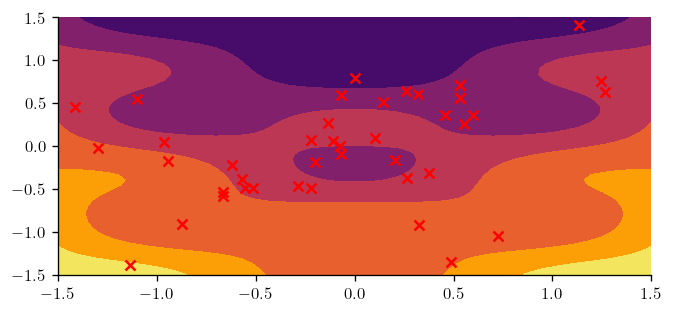

In [3]:
# ground truth function
def f(x): 
    return (x[:,0:1]**2 - 2*x[:,1:2] + jnp.cos(3*x[:,0:1])*jnp.sin(5*x[:,1:2]))

# simulate a noisy dataset of 50 noisy observations
n, noise = 50, 0.01
X = jr.normal(jr.PRNGKey(12345), shape=(n,2)) 
y = f(X) + jr.normal(jr.PRNGKey(12345), shape= (n, 1)) * noise
D = gpx.Dataset(X=X, y=y)

# plot the ground truth function
fig, ax = plt.subplots()
contour_plot(f(xplot2d), ax)

## Build an "Additive Gaussian Process"

todo we need a kernel

note use girad newton to speed things up

also has additional method to extract sub components

In [4]:
@dataclass()
class AdditiveKernel(gpx.kernels.AbstractKernel):
    r"""An Additive Kernel ."""
    kernels: list[gpx.kernels.AbstractKernel] = None
    max_interaction_depth: ScalarInt = gpx.base.static_field(1)
    interaction_variances: Float[Array, " p"] = gpx.param_field(jnp.array([1.0, 1.0]), bijector=tfb.Softplus())
    max_interaction_depth: ScalarInt = gpx.base.static_field(1)
    name: str = "AdditiveKernel"

    def __post_init__(self): # jax/jit requires specifying max_interaction depth even though this could be infered from length of interaction_variances
        assert self.max_interaction_depth == len(self.interaction_variances) - 1, "Number of interaction variances must be equal to max_interaction_depth + 1"

    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute the additive kernel between a pair of arrays."""
        x = self.slice_input(x) # [d]
        y = self.slice_input(y) # [d]
        ks = jnp.stack([k(x,y) for k in self.kernels])
        return jnp.dot(self._compute_additive_terms_girad_newton(ks), self.interaction_variances)
            
    @jax.jit   
    def _compute_additive_terms_girad_newton(self, ks: Num[Array, " D"]) -> ScalarFloat:
        r"""Given a list of inputs, compute a new list containing all products up to order
        `max_interaction_depth`. For efficiency, we us the Girad Newton identity 
        (i.e. O(d^2) instead of exponential).
        """
        powers = jnp.arange(self.max_interaction_depth + 1)[:, None] # [p + 1, 1]
        s = jnp.power(ks[None, :],powers) # [p+1, d]
        e = jnp.ones(shape=(self.max_interaction_depth+1), dtype=jnp.float64) # lazy init then populate
        for n in range(1, self.max_interaction_depth + 1): # has to be for loop because iterative
            thing = jax.vmap(lambda k: ((-1.0)**(k-1))*e[n-k]*s[k, :])(jnp.arange(1, n+1))
            e = e.at[n].set((1.0/n) *jnp.sum(thing))
        return jnp.array(e) # [max_interaction_depth + 1]
    
    def get_specific_kernel(self, component_list: List[int] = []) -> gpx.kernels.AbstractKernel:
        r""" Get a specific kernel from the additive kernel corresponding to component_list."""
        var = self.interaction_variances[len(component_list)]
        kernel = gpx.kernels.Constant(constant = var)
        for i in component_list:
            kernel = kernel * self.kernels[i]
        return kernel

In [5]:
class AdditivePosterior(gpx.gps.ConjugatePosterior):
    r"""todo"""

    def __post__init__(self):
        assert isinstance(self.prior.kernel, AdditiveKernel), "AdditivePosterior requires an AdditiveKernel"

    def predict_additive_component(
        self,
        test_inputs: Num[Array, "N D"],
        train_data: gpx.Dataset,
        component_list: List[List[int]]
    ) -> GaussianDistribution:
        r"""Get the posterior predictive distribution for a specific additive component."""
        specific_kernel = self.prior.kernel.get_specific_kernel(component_list)
        Kxx = self.prior.kernel.gram(train_data.X)
        Kxt = specific_kernel.cross_covariance(train_data.X, test_inputs)
        Sigma = cola.PSD(Kxx + cola.ops.I_like(Kxx) * self.likelihood.obs_stddev**2)
        Sigma_inv_Kxt = cola.solve(Sigma, Kxt)
        mean =  jnp.matmul(Sigma_inv_Kxt.T, train_data.y)
        covariance = specific_kernel.gram(test_inputs) - jnp.matmul(Kxt.T, Sigma_inv_Kxt)
        return GaussianDistribution(jnp.atleast_1d(mean.squeeze()), cola.PSD(covariance))

    def get_sobol_index(self, train_data: gpx.Dataset, component_list: List[int]) -> ScalarFloat:
        """ Return the sobol index for the additive component corresponding to component_list. """
        component_posterior = self.predict_additive_component(train_data.X, train_data, component_list)
        full_posterior= self.predict(train_data.X, train_data)
        return jnp.var(component_posterior.mean()) / jnp.var(full_posterior.mean())



Now lets try on the dataset. we fit additive models of `max_interaction_depth` 0 (i.e. a constant model), 1 and 2.

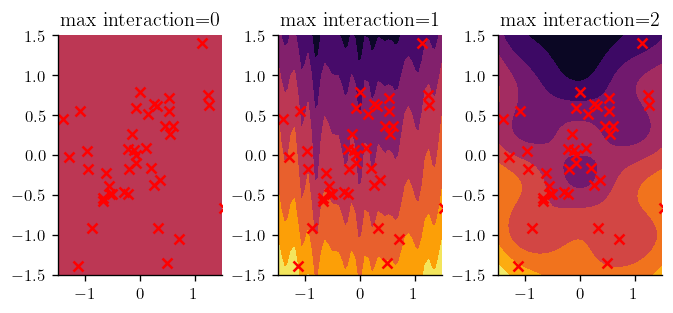

In [6]:
meanf = gpx.mean_functions.Zero()
base_kernels = [gpx.kernels.RBF(active_dims=[0], lengthscale=jnp.array([0.1])), gpx.kernels.RBF(active_dims=[1], lengthscale=jnp.array([0.1]))]
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=noise)
obj = gpx.objectives.ConjugateLOOCV(negative=True)

fig, ax = plt.subplots(nrows=1, ncols=3)
for i in [0,1,2]:
    
    kernel = AdditiveKernel(
        kernels=base_kernels,
        interaction_variances=jnp.array([1.0]*(i+1)) * jnp.var(D.y), 
        max_interaction_depth=i, 
        )

    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
    posterior = AdditivePosterior(prior =prior, likelihood=likelihood)
    opt_posterior, history = gpx.fit_scipy(model=posterior, objective=obj, train_data=D, verbose=False)
    contour_plot(opt_posterior.predict(xplot2d, D).mean(), ax[i])
    ax[i].set_title(f"max interaction={i}")


We can also look at the individual additive components learned by the second order model

In [7]:
# plotting util
def plot_posterior_with_components(opt_posterior, sobol=False):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    for i in [0,1]: # make 1d plots of 1d interactions
        posterior = opt_posterior.predict_additive_component(xplot1d, D, [i])
        mean, std = posterior.mean(), posterior.stddev()
        ax[i].plot(xplot1d[:,i], mean, color="blue", label="additive")
        ax[i].fill_between(xplot1d[:,i], mean - 2 * std,mean + 2 * std, alpha=0.2, color="blue")
        ax[i].set_title(f"$f_{i}(x_{i})$" if not sobol else f"$f_{i}(x_{i}) has sobol {opt_posterior.get_sobol_index(D, [i]):.2f}$")
        truth = xplot1d[:,i]**2 if i==0 else -2*xplot1d[:,i]
        ax[i].plot(xplot1d[:,i], truth, color="black", label="truth")
        ax[i].legend()

    # plot 2d interaction
    ax[2].set_title(f"$f_3(x_1,x_2)$" if not sobol else f"$f_3(x_1,x_2) has sobol {opt_posterior.get_sobol_index(D, [0, 1]):.2f}$")
    contour_plot(opt_posterior.predict_additive_component(xplot2d, D, [0, 1]).mean(), ax[2])



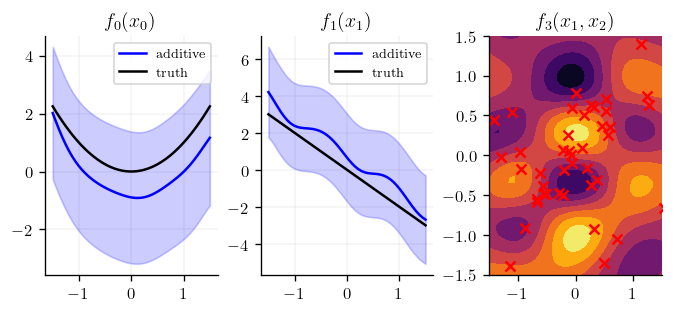

In [8]:
# plot learned additive components
plot_posterior_with_components(opt_posterior)

Say this is somewhat dissapointing as so much uncertainty!

## Roll on the "Orthogonal Additive Kernel"

This does something better .... todo

Say this implementation requires gaussian input measure and zero mean function

In [9]:
@dataclass()
class OrthogonalRBF(gpx.kernels.AbstractKernel):
    r"""todo only for unit gaussian input measure and zero mean."""
    name: str = "OrthogonalRBF"
    lengthscale: Union[ScalarFloat, Float[Array, " D"]] = gpx.param_field(
        jnp.array(1.0), bijector=tfb.Softplus()
    )

    def __post_init__(self):
        warnings.warn("This kernel is only valid for unit gaussian input measures and zero mean functions.")

    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute an orthogonal RBF kernel between a pair of arrays."""
        x = self.slice_input(x) # [d]
        y = self.slice_input(y) # [d]
        ks = jnp.exp(-0.5 * ((x - y) / self.lengthscale) ** 2) # [d]
        ks -=  self._cov_x_s(x) * self._cov_x_s(y) / self._var_s() # [d]
        return jnp.prod(ks)
    
    def _cov_x_s(self,x):
        l2 = self.lengthscale ** 2
        return jnp.sqrt(l2 / (l2 + 1.0)) * jnp.exp(-0.5 * (x ** 2) / (l2 + 1.0)) # [d]
        
    def _var_s(self):
        return  jnp.sqrt(self.lengthscale ** 2 / (self.lengthscale ** 2 + 2.0)) # [d]


Now lets recreate the plots from before

/tmp/ipykernel_117984/3421494739.py:10: UserWarning: This kernel is only valid for unit gaussian input measures and zero mean functions.
  warnings.warn("This kernel is only valid for unit gaussian input measures and zero mean functions.")


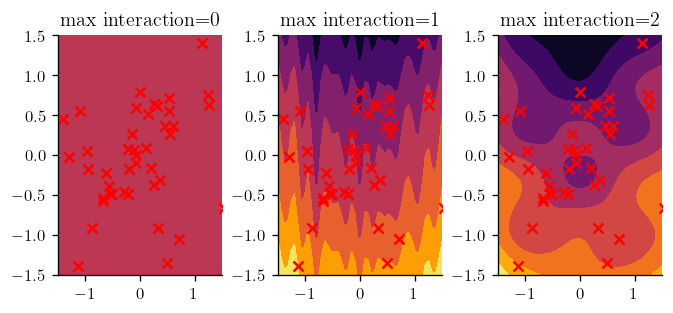

In [10]:
base_kernels = [OrthogonalRBF(active_dims=[0], lengthscale=jnp.array([0.1])), OrthogonalRBF(active_dims=[1], lengthscale=jnp.array([0.1]))]

fig, ax = plt.subplots(nrows=1, ncols=3)
for i in [0,1,2]:
    
    kernel = AdditiveKernel(
        kernels=base_kernels,
        interaction_variances=jnp.array([1.0]*(i+1)) * jnp.var(D.y), 
        max_interaction_depth=i, 
        )

    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
    posterior = AdditivePosterior(prior =prior, likelihood=likelihood)
    opt_posterior, history = gpx.fit_scipy(model=posterior, objective=obj, train_data=D, verbose=False)
    contour_plot(opt_posterior.predict(xplot2d, D).mean(), ax[i])
    ax[i].set_title(f"max interaction={i}")


Also can plot components learned by the 2nd order model

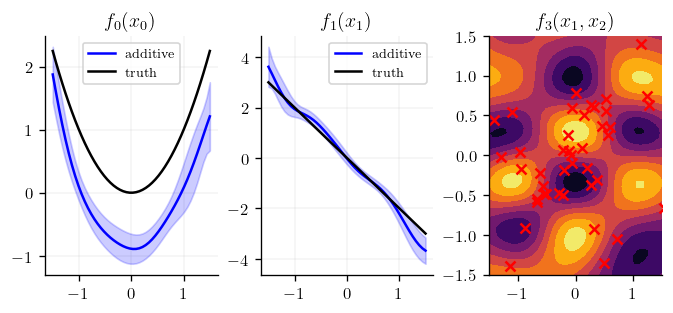

In [11]:
# plot additive components
plot_posterior_with_components(opt_posterior)